# Deflection Angle Calculation

**Importing libraries**

In [17]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.halo import mass_defs
from colossus.halo import mass_so


dpi = 150 #figures' dots per inch

**Defining constants**

$\lambda$-CDM parameters from [https://en.wikipedia.org/wiki/Lambda-CDM_model](https://en.wikipedia.org/wiki/Lambda-CDM_model)

In [18]:
H_o = 67.74       #Hubble constant in km s^−1 Mpc^−1
h = H_o/100       #scaled Hubble constant 
omega_m = 0.3089  #matter density parameter 
omega_l = 0.6911  #vacuum density parameter

c = 2.99792458e5  #speed of light in km/s                     
G = 4.30091 * 10**(-3) / (10**(6))   #Gavitational constant in Mpc M_sun^−1  (km/s)^2

**Defining functions for**
1. Comoving distance
2. Hubble parameter
3. Critical density
4. r$_{200}$
5. Concentration
6. Scale radius
7. Density parameter
8. NFW density profile
9. NFW mass profile

In [19]:
cosmology.setCosmology('planck18')

def comov_dist_func(z):             #comoving distance in Mpc using Eq. 4.53 in Peter (2015)
    return (c/H_o) * integrate.quad(lambda a: 1/np.sqrt(a * omega_m +  a**4 * omega_l), np.power(1+z,-1), 1)[0]

def H(z):                           #hubble parameter (in km s^-1 Mpc^-1) using Eq. 4.33 in Peter's book
    return np.sqrt( H_o**2 * ( (1+z)**3 * omega_m + omega_l ) ) 

def rho_cric_func(z):               #critical density in M_sun Mpc^-3
    return 3 * H(z)**2 / (8 * np.pi * G) 



def r_200(M_200, z_l):              #r_200c in Mpc. Output of M_to_R is in kpc/h.
    return mass_so.M_to_R(M_200, z_l, '200c') * h / 10**3    

def c_200_func(M_200, z_l):
    return concentration.concentration(M_200, '200c', z_l, model = 'diemer15') 

def R_s_func(M_200, z_l):           #Scale radius in Mpc
    return r_200(M_200, z_l)/c_200_func(M_200, z_l) 

def rho_o_func(M_200, z_l):         #density paremter (in M_sun Mpc^-3) from eq. next to eq. 7.61 in Peter's book
    c_200 = c_200_func(M_200, z_l)  
    return 200/3 * rho_cric_func(z_l)  * np.power(c_200, 3) / ( np.log(1+c_200) - c_200/(1+c_200) )

def rho(r, M_200, z_l):             #NFW Density Profile (in M_sun Mpc^-3)
    R_s = R_s_func(M_200, z_l)  
    return rho_o_func(M_200, z_l) / ((r/R_s)*(1+(r/R_s))**2 ) 

def M(r, M_200, z_l, rho = 'no'):   #NFW Mass profile in M_sun from https://en.wikipedia.org/wiki/Navarro–Frenk–White_profile
    R_s = R_s_func(M_200, z_l) 
    return 4 * np.pi * rho_o_func(M_200, z_l) * np.power(R_s,3) * (np.log((R_s + r)/R_s) - r/ (R_s + r)) 

**Dodelson (2003) functions**

In [20]:
cosmology.setCosmology('planck18')
def lambda_func(theta, M_200, z_l):
    X_l = comov_dist_func(z_l)
    return X_l * theta / ((1+z_l) * R_s_func(M_200, z_l)) 

def f_func(theta, M_200, z_l):
    Lambda = lambda_func(theta, M_200, z_l)          #parameter in Dodelson (2003)

    f = np.zeros(np.shape(theta))                    #parameter in Dodelson (2003)
    print(f.shape)
    for i in range(np.shape(Lambda)[0]):
        for j in range(np.shape(Lambda)[1]):   
            if Lambda[i][j] < 1:
                f[i][j] = (3.23 / Lambda[i][j]) * (np.log(Lambda[i][j]/2) + 
                np.log(Lambda[i][j] /(1-np.sqrt(1-Lambda[i][j]**2))) / np.sqrt(1-Lambda[i][j]**2))
                
            else:
                f[i][j] = (3.23 / Lambda[i][j]) * (np.log(Lambda[i][j]/2) + 
                (np.pi/2 - np.arcsin(1/Lambda[i][j]) ) / np.sqrt(Lambda[i][j]**2 - 1) )

    return f

def v_max_func(M_200, z_l):
    return 0.46 * np.sqrt(4 * np.pi * G * rho_o_func(M_200, z_l) * R_s_func(M_200, z_l)**2) 

def d_theta_dodelson(r, M_200, z_l):
    v_max = v_max_func(M_200, z_l)
    X_l = comov_dist_func(z_l)
    X_s = comov_dist_func(1100.0)
    theta = r/X_l
    f = f_func(theta, M_200, z_l)
    return 0.54 * (v_max/200)**2  * (X_s - X_l) * (f / X_s) 

## Coma NFW cluster density and mass profiles

Coma cluster parameter form  ́[Sanchez-Conde (2011)](https://arxiv.org/abs/1104.3530)

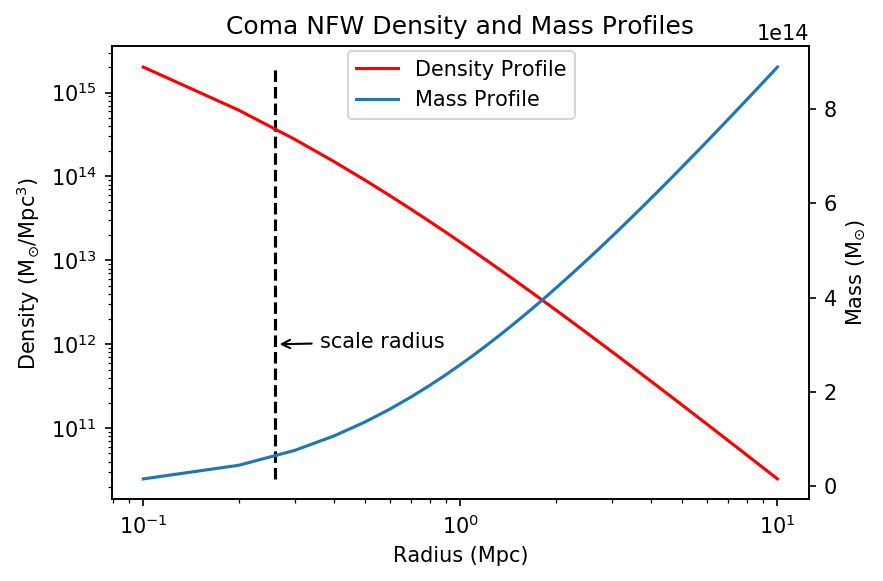

In [21]:
cosmology.setCosmology('planck18')

M_200 = 13.8E14/h                   #Mass_200c (not sure of c) of Coma cluster in M_sun/h
z_l = 0.5                           #Redshift of lensing cluster


#To interconvert masses
M_500c, R_500c, c_500c = mass_defs.changeMassDefinition(M_200, c_200_func(M_200, z_l), z_l, '200c', '500c', profile = 'nfw')


R_max = 10.00                      #Maximum radial distance in Mpc where theta is calculated 
r = np.linspace(0.1, R_max, 100)   #radial distances from cluster in Mpc

fig, ax1 = plt.subplots(dpi = dpi)

ax1.plot(r, rho(r, M_200, z_l), c = 'r', label = 'Density Profile')
ax1.set_xlabel('Radius (Mpc)')
ax1.set_ylabel('Density (M$_{\odot}$/Mpc$^{3}$)')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(r,M(r, M_200, z_l), label = 'Mass Profile')
ax2.set_ylabel('Mass (M$_{\odot}$)')

ax1.vlines(x=R_s_func(M_200, z_l), ymin = min(rho(r,M_200,z_l)), ymax = max(rho(r, M_200, z_l)), 
            linestyle = 'dashed')

ax1.annotate('scale radius', (R_s_func(M_200, z_l), 1e12), xytext = (R_s_func(M_200, z_l)+0.1, 0.9e12),
                arrowprops = dict(arrowstyle = "->") )

plt.title('Coma NFW Density and Mass Profiles')
fig.legend(bbox_to_anchor=(0.65, 0.9));

## Deflection Angle for Coma NFW cluster
#### Radial plot for various redshifts with $\theta$ axis in arcsec
Deflection angle formula from Vale (2004)

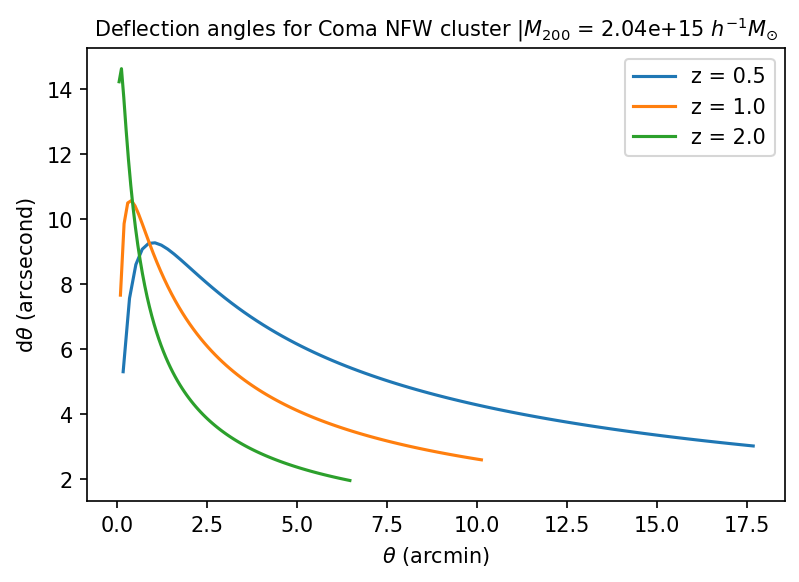

In [22]:
cosmology.setCosmology('planck18')

X_s = comov_dist_func(1100.0)             #Comoving distance of LSS in Mpc  


plt.figure(dpi=dpi)

#deflection angles profile at z = 0.5
X_l_0_5 = comov_dist_func(z_l)            #Comoving distance of cluster in Mpc 
theta = np.arctan(r/X_l_0_5)              #angular distance away from cluster center
d_theta = (4 * G / c**2) * ((X_s - X_l_0_5)/(X_s * X_l_0_5)) * (M(r, M_200, z_l)/theta) * (180/np.pi) * 3600 
plt.plot(theta* (180/np.pi) * 60, d_theta, label = 'z = 0.5')


#deflection angles profile at z = 1.0
z = 1.0
X_l = comov_dist_func(1.0)
theta_1_0 = np.arctan(r/X_l)
d_theta_z_1_0 = (4 * G / c**2) * ((X_s - X_l)/(X_s * X_l)) * (M(r, M_200, 1.0)/ theta_1_0 ) * (180/np.pi) * 3600
plt.plot(theta_1_0* (180/np.pi) * 60, d_theta_z_1_0, label = 'z = 1.0')


#deflection angles profile at z = 2.0
z = 2.0
X_l = comov_dist_func(2.0)
theta_2_0 = np.arctan(r/X_l)
d_theta_z_2_0 = (4 * G / c**2) * ((X_s - X_l)/(X_s * X_l)) * (M(r, M_200, 2.0)/ theta_2_0 ) * (180/np.pi) * 3600 
plt.plot(theta_2_0* (180/np.pi) * 60, d_theta_z_2_0, label = 'z = 2.0')

plt.legend()
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'd$\theta$ (arcsecond)')
plt.title(r'Deflection angles for Coma NFW cluster |$M_{200}$ = ' + '{:.2e}'.format(M_200) + ' $h^{-1}  M_{\odot}$', fontsize=10);

#### Radial plot for various redshifts with $\theta$ axis in terms of $\theta_s$

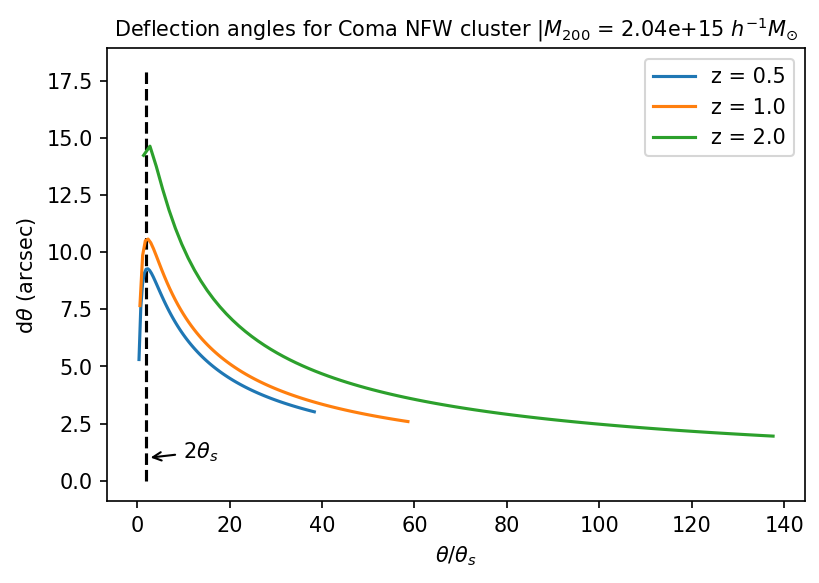

In [23]:
cosmology.setCosmology('planck18')

plt.figure(dpi = dpi)

theta_s_0_5 = np.arctan(R_s_func(M_200, 0.5)/comov_dist_func(0.5))
plt.plot(theta / theta_s_0_5, d_theta, label = 'z = 0.5')

theta_s_1_0 = np.arctan(R_s_func(M_200, 1.0)/comov_dist_func(1.0))
plt.plot(theta_1_0 / theta_s_1_0, d_theta_z_1_0, label = 'z = 1.0')

theta_s_2_0 = np.arctan(R_s_func(M_200, 2.0)/comov_dist_func(2.0))
plt.plot(theta_2_0 / theta_s_2_0, d_theta_z_2_0, label = 'z = 2.0')

plt.vlines(x=2, ymin = 0, ymax = 18, linestyle = 'dashed')
plt.annotate(r'2$\theta_s$', (2, 1), xytext = (10, 1),
                arrowprops = dict(arrowstyle = "->") )

plt.legend()
plt.xlabel(r'$\theta / \theta_s$ ')
plt.ylabel(r'd$\theta$ (arcsec)')
plt.title(r'Deflection angles for Coma NFW cluster |$M_{200}$ = ' + '{:.2e}'.format(M_200) + ' $h^{-1}  M_{\odot}$', fontsize=10);

#### Radial plot: Vale (2004) vs Dodelson (2003)

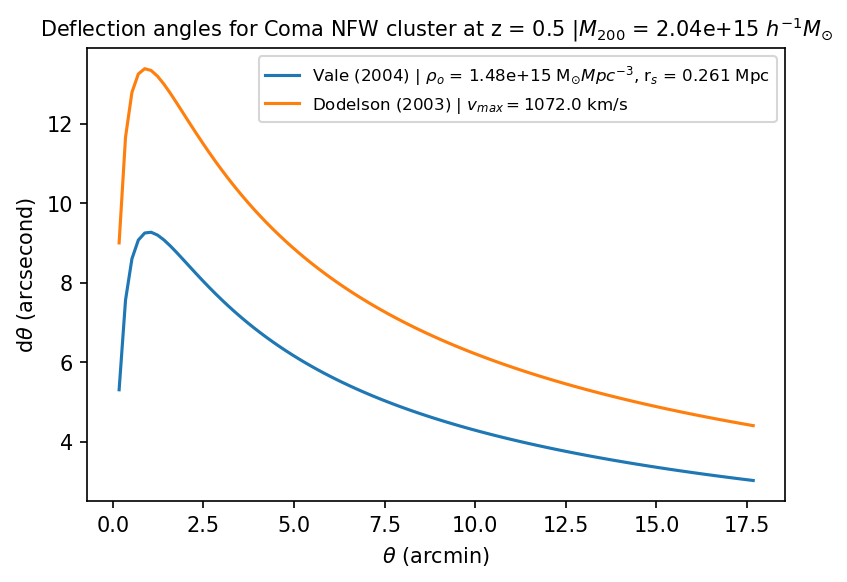

In [24]:
cosmology.setCosmology('planck18')

plt.figure(dpi = dpi)

#Using formula of Vale (2004)
plt.plot(theta* (180/np.pi) * 60, d_theta, 
         label = r'Vale (2004) | $\rho_o$ = {:.3} '.format(rho_o_func(M_200, z_l)) 
         + 'M$_{\odot} Mpc^{-3}$, ' + 'r$_s$ = {:.3} Mpc'.format(R_s_func(M_200, z_l)) )



#Using formulas of Dodelson (2003)
z_l = 0.5
X_l = comov_dist_func(0.5)

Lambda = X_l * theta / ((1+z_l) * R_s_func(M_200, 0.5))       #parameter in Dodelson (2003)

f = np.zeros(len(theta))                                      #parameter in Dodelson (2003)
for i in range(len(Lambda)):
    if Lambda[i] < 1:
        f[i] = (3.23 / Lambda[i]) * (np.log(Lambda[i]/2) + 
        np.log(Lambda[i] /(1-np.sqrt(1-Lambda[i]**2))) / np.sqrt(1-Lambda[i]**2))
        
    else:
        f[i] = (3.23 / Lambda[i]) * (np.log(Lambda[i]/2) + 
        (np.pi/2 - np.arcsin(1/Lambda[i]) ) / np.sqrt(Lambda[i]**2 - 1) )

#maxiumum rotational velocity in km/s
v_max = 0.46 * np.sqrt(4 * np.pi * G * rho_o_func(M_200, 0.5) * R_s_func(M_200, 0.5)**2) 

d_theta_NFW = 0.54 * (v_max/200)**2  * (X_s - X_l) * f / X_s

plt.plot(theta * (180/np.pi) * 60, d_theta_NFW, 
         label = r'Dodelson (2003) | $v_{max}'+' = {} $ km/s'.format(str(np.round(v_max,1))) )
plt.legend(fontsize = 8)
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'd$\theta$ (arcsecond)')
plt.title(r'Deflection angles for Coma NFW cluster at z = 0.5 |$M_{200}$ = ' + '{:.2e}'.format(M_200) + ' $h^{-1}  M_{\odot}$', fontsize=10);

#### Surface plot for Coma cluster at z = 0.5

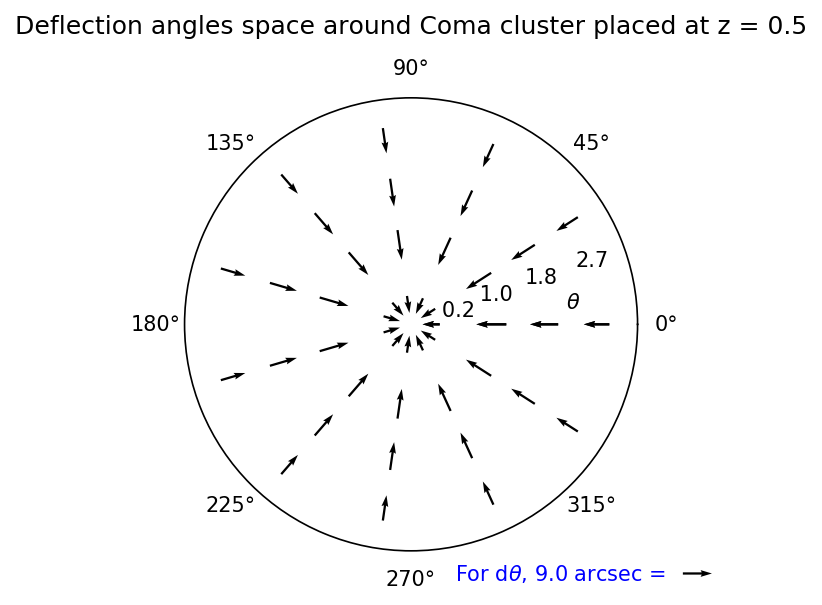

In [25]:
cosmology.setCosmology('planck18')

#Calculating deflection angles
no_of_arrows = 4
R_max = 1.5
r = np.linspace(0.1, R_max, no_of_arrows)
z_l = 0.5
X_l = comov_dist_func(0.5)
theta = np.arctan(r/comov_dist_func(0.5))     
d_theta = (4 * G / c**2) * ((X_s - X_l)/(X_s * X_l)) * (M(r, M_200, z_l)/theta) * (180/np.pi) * 3600 


#Generating 2d arrays required for quiver plot
theta_polar = np.linspace(0, 2 * np.pi, 12)
r_polar = theta * (180/np.pi) * 60

theta_mesh, r_mesh = np.meshgrid(theta_polar, r_polar)

useless, d_theta_scale_factor = np.meshgrid(theta_polar, d_theta)

d_theta_x = - r_mesh/r_mesh * np.cos(theta_mesh) * d_theta_scale_factor
d_theta_y = - r_mesh/r_mesh * np.sin(theta_mesh) * d_theta_scale_factor


#Plotting and tweaking the quiver plot
f = plt.figure(dpi=dpi)
ax = f.add_subplot(111, polar=True)

Quiver = ax.quiver(theta_mesh, r_mesh,d_theta_x,d_theta_y
            ,pivot = 'tip'
            # ,scale = 80
            ,width = 0.005
            )

plt.grid(False)

r_ticks = np.linspace(min(r_polar), max(r_polar)+ r_polar[1]-r_polar[0], no_of_arrows+1)
r_labels = list(np.round(r_ticks,1))
r_labels[0] = '   ' + str(r_labels[0])
r_labels[1] = ' ' + str(r_labels[1])
r_labels[-1] = '   ' 
ax.set_rgrids(r_ticks, labels = r_labels)

ax.set_rlabel_position(18)

plt.quiverkey(Quiver, 1.1, -0.05, round(max(d_theta))
                    , label= r'For d$\theta$, ' + str(round(max(d_theta))) + ' arcsec = '
                    , labelcolor='blue'
                    , labelpos='W',
                   coordinates='axes')

ax.text(0.1, 0.9*max(r_polar), r'$\theta$')
ax.set_title('Deflection angles space around Coma cluster placed at z = 0.5', pad=20);

## Deflection angle profiles for SIS, a modified SIS and NFW galaxies at z = 0.2

Deflection angle from eq. (3) of Dodelson (2003):

$$
\overrightarrow{\delta \theta}=-8 \pi G \frac{\vec{\theta}}{\theta}\frac{\left(\chi_{S}-\chi_{L}\right)}{\chi_{S}}
\left[\frac{1+z_{L}}{\theta \chi_{L}} \int_{0}^{\chi_{L} \theta /\left(1+z_{L}\right)} d R R \Sigma(R)\right]
$$


##### Spherical isothermal sphere |  $\mathbf{ \rho(r) = \rho_{m}\left(r_{0} / r\right)^{2}}$. 
The (2D) surface density of SIS by including contributions inside r$_o$ is:
$$\Sigma(R)= \frac{2\rho_{m} r_{o}^{2}}{R} \left(\frac{\pi}{2} - \mathrm{arcsin} \left(\frac{R}{r_o}\right)\right)$$

 which makes:

$$
\overrightarrow{\delta \theta}=-8 \pi G \frac{\vec{\theta}}{\theta}
\frac{\left(\chi_{S}-\chi_{L}\right)}{\chi_{S}} 2\rho_{m} r_{o}^{2} 
\left[\frac{\pi}{2} - \mathrm{arcsin} \left(\frac{\theta \chi_{L}}{(1+z_{L})r_o}\right)
- \frac{1+z_{L}}{\theta \chi_{L}} \left(\sqrt{r_o^2 - \left(\frac{\theta \chi_{L}}{1+z_{L}} \right)} 
  - r_o \right)  \right]
$$

##### Modified SIS | $\mathbf{ \rho(r)=\rho_{m}\left(r_{\circ} / r\right)^{1.8}}$
The surface density, again, incorporating mass inside r$_o$ is $ \Sigma (R) = 2 \rho_{m} r_{\circ}^{1.8} \int_R^{r_o} \frac{dr}{r^{0.8}\sqrt{r^2-R^2}} $. 

The deflection angle in this case is:

$$
\overrightarrow{\delta \theta} =-8 \pi G \frac{\vec{\theta}}{\theta}
\frac{\left(\chi_{S}-\chi_{L}\right)}{\chi_{S}}\left[\frac{1+z_{L}}{\theta \chi_{L}} 2 \rho_{m} r_{\circ}^{1.8} 
 \int_{0}^{\chi_{L} \theta /\left(1+z_{L}\right)} \mathrm{R}  d R 
 \int_{R}^{r_o} \frac{dr}{r^{0.8} \sqrt{r^2 - R^2}}   \right]
$$


##### NFW Profile | $\rho\left(x \equiv r / r_{s}\right)=\rho_{s}/x(1+x)^{2}$

Eq. 6 of Dodelson (2003):

$$\left.\delta \vec{\theta}\right|_{\mathrm{NFW}}=-0.54^{\prime \prime} \frac{\vec{\theta}}{\theta}\left(\frac{v_{\max }}{200 \mathrm{km} \sec ^{-1}}\right)^{2} \frac{\left(\chi_{S}-\chi_{L}\right)}{\chi_{S}} f(\lambda)$$
where $f(\lambda)$ is a smooth function:
$$f(\lambda) \equiv \frac{3.23}{\lambda}\left\{\begin{array}{ll}{\ln (\lambda / 2)+\frac{\ln (\lambda /[1-\sqrt{1-\lambda^{2}})}{\sqrt{1-\lambda^{2}}}} & {\lambda<1} \\ {\ln (\lambda / 2)+\frac{\pi / 2-\arcsin (1 / \lambda)}{\sqrt{\lambda^{2}-1}}} & {\lambda>1}\end{array}\right. $$

$$\lambda \equiv \frac{\chi_{L} \theta}{\left(1+z_{L}\right) r_{s}}$$

$$ r_{s} = v_{\max } / 0.46\left(4 \pi G \rho_{s} \right)^{1/2} $$

From Eq. next to Eq. 7.61 in Peter (2014) book:

$$\rho_{\mathrm{s}}=\frac{200}{3} \rho_{\mathrm{cr}}(z) \frac{c^{3}}{\ln (1+c)-c /(1+c)}$$


/home/centro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/home/centro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/home/centro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purp

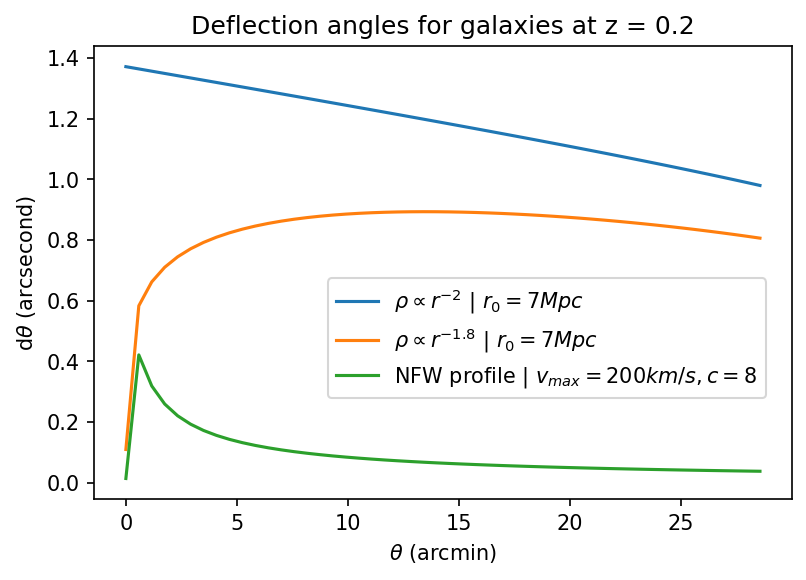

In [26]:
rho_m = 0.9 * H_o**2 / (8 * np.pi * G) #current matter density of universe in M_sun/Mpc
r_o =  7                               #correlation length in Mpc
z_l = 0.2                              #redshift of lensing galaxy
X_l = comov_dist_func(0.2)             #comoving distance of lensing galaxy

r = np.linspace(0.0001, r_o, 50)       #radi of galaxy

theta = np.arctan(r/X_l)               #angles from center of galaxy

###############################################################################################################
#deflection angles for r^-2 dependence

d_theta =  8 * np.pi * (G/(c**2)) * ((X_s - X_l)/X_s) * (1+z_l)/(theta * X_l) * \
            -2 * rho_m * r_o**2 * ( (X_l*theta)/(1+z_l) * np.arcsin((X_l*theta)/(1+z_l)/r_o) +  \
          np.sqrt(r_o**2 - ((X_l*theta)/(1+z_l))**2 ) - (np.pi/2) * (X_l*theta)/(1+z_l) - r_o) * (180/np.pi) * 3600


plt.figure(dpi=dpi)

plt.plot(theta * (180/np.pi) * 60, d_theta, label = r'$\rho \propto r^{-2} $ | $  r_{0} = 7 Mpc$  ')
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'd$\theta$ (arcsecond)')


##################################################################################################################
#deflection angles for r^-1.8 dependence

def Sigma_1_8(R):
    return integrate.quad(lambda r: 1/(r**0.8 * np.sqrt(r**2 - R**2)), R, r_o)[0]

d_theta_1_8 = np.zeros(len(theta))

for i in range(len(theta)):
    d_theta_1_8[i] = 8 * np.pi * (G/(c**2)) * ((X_s - X_l)/X_s) * ((1+z_l)/(theta[i] * X_l)) * 2 * rho_m * r_o**1.8 * \
                 integrate.quad(lambda R: R *  Sigma_1_8(R), 0, (X_l*theta[i])/(1+z_l) )[0] * (180/np.pi) * 3600

plt.plot(theta * (180/np.pi) * 60, d_theta_1_8 , label = r'$\rho \propto r^{-1.8}$ | $  r_{0} = 7 Mpc$' )


###################################################################################################################
#deflection angles for NFW profile

v_max = 200  #maxiumum rotational velocity in km/s
cc = 8       #concentration


rho_cric = 3 * H(z_l)**2 / (8 * np.pi * G)               #critical density of universe at the given redshift in M_sun/Mpc
rho_s = 200/3 * rho_cric * cc**3 / ( np.log(1+cc) - cc/(1+cc) ) #density paremter from eq. next to eq. 7.61 in Peter's book

r_s = v_max / ( 0.46 * np.sqrt(4 * np.pi * G * rho_s) ) #scale radius in Mpc

Lambda = X_l * theta / ((1+z_l) * r_s)                  #parameter in Dodelson (2003)

f = np.zeros(len(theta))                                #parameter in Dodelson (2003)

for i in range(len(Lambda)):
    if Lambda[i] < 1:
        f[i] = (3.23 / Lambda[i]) * (np.log(Lambda[i]/2) + np.log(Lambda[i] /(1-np.sqrt(1-Lambda[i]**2))) / np.sqrt(1-Lambda[i]**2))
        
    else:
        f[i] = (3.23 / Lambda[i]) * ( np.log(Lambda[i]/2) + (np.pi/2 - np.arcsin(1/Lambda[i]) ) / np.sqrt(Lambda[i]**2 - 1) )

d_theta_NFW = 0.54 * (v_max/200)**2  * (X_s - X_l) * f / X_s


plt.title('Deflection angles for galaxies at z = 0.2')
plt.plot(theta * (180/np.pi) * 60, d_theta_NFW, label = r'NFW profile | $v_{max} = 200 km/s,  c = 8$')
plt.legend(bbox_to_anchor=(0.32, 0.2));

#### Comparison of SIS surface density profiles with contributions of whole sphere and contributions only inside r$_o$

/home/centro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arcsin
  This is separate from the ipykernel package so we can avoid doing imports until


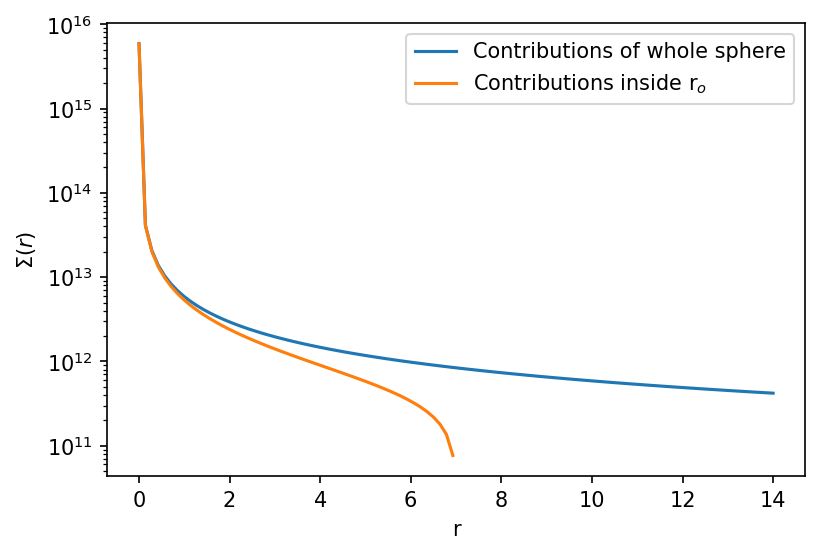

In [27]:
r = np.linspace(0.001, 2*r_o, 100)
surf_den = np.pi * rho_m * r_o**2 / r
surf_den_r_o = (2 * rho_m * r_o**2 /r) * (np.pi/2 - np.arcsin(r/r_o))

plt.figure(dpi=dpi)
plt.plot(r, surf_den, label = 'Contributions of whole sphere')
plt.plot(r, surf_den_r_o, label = r'Contributions inside r$_o$')
plt.xlabel('r')
plt.ylabel('$\Sigma (r)$')
plt.yscale('log')
plt.legend()